In [82]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest
import os

from skimage.metrics import peak_signal_noise_ratio

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(dev)
if dev is 'cuda':
  dtype = torch.cuda.FloatTensor
else:
  dtype = torch.FloatTensor
print(f'Using device {device}')

Using device cpu


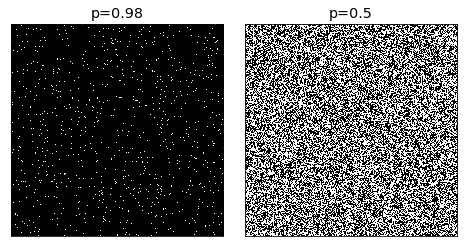

In [84]:
from utils import *
mask = torch.from_numpy(get_bernoulli_mask((3,500,500), 0.98))
mask[1] = mask[0]
mask[2] = mask[0]
mask2 = torch.from_numpy(get_bernoulli_mask((3,256,256), 0.5))
mask2[1] = mask2[0]
mask2[2] = mask2[0]
fig, axes = tensors_as_images([mask, mask2], 
                                        titles=['p=0.98', 'p=0.5'])

In [85]:
from models import *
from models.unet import *

# Change IMAGE to kate|barbara
IMAGE = 'kate'
checkpoint_file = f'checkpoints/restoration_{IMAGE}'

input_depth = 32

if IMAGE == 'barbara':
    net = UNet(input_depth, 1, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5)

elif IMAGE == 'kate':
    net = UNet(input_depth, 3, [16, 32, 64, 128, 128], [16, 32, 64, 128, 128], [0]*5,
              [3]*5, [3]*5, [1]*5)
else:
    assert False
    
net.to(device)

print(f'Image is {IMAGE}')
print(net)

show_every = 50

Image is kate
UNet(
  (downs): ModuleList(
    (0): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv2): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
        (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): DownsampleBlock(
      (conv1): ConvBlock(
        (pad): ReflectionPad2d((1, 1, 1, 1))
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (conv2): ConvB

In [86]:
s = sum([np.prod(list(p.size())) for p in net.parameters()])
print(f'Number of params: {s}')

# Loss 
mse = torch.nn.MSELoss()

Number of params: 1027379


# Regular Training without input optimization

Image dim : (3, 512, 512)


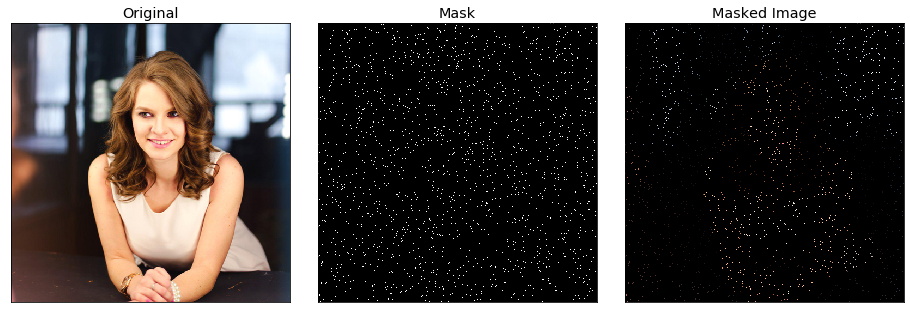

In [87]:
from utils import *
from input_gen import *

reg_noise_std = 1./30.

fname_barbara = 'data/restoration/barbara.png'
fname_kate = 'data/restoration/kate.png'
fname = fname_barbara if IMAGE == 'barbara' else fname_kate

img_pil = crop_image(get_image(fname, -1)[0])
img_np = pil_to_np(img_pil)
img_tr = torch.from_numpy(img_np).type(dtype)

if IMAGE == 'barbara':
    img_mask_np = get_bernoulli_mask(img_np.shape, 0.5)
elif IMAGE == 'kate':
    img_mask_np = get_bernoulli_mask(img_np.shape, 0.98)
    img_mask_np[1] = img_mask_np[0]
    img_mask_np[2] = img_mask_np[0]
    
img_tr = torch.from_numpy(img_np).type(dtype)
mask_tr = torch.from_numpy(img_mask_np).type(dtype)
img_masked = img_np * img_mask_np
img_masked_tr = torch.from_numpy(img_masked).type(dtype)

print(f'Image dim : {img_np.shape}')
fig, axes = tensors_as_images([img_tr, mask_tr, img_masked_tr],
                              titles=['Original', 'Mask', 'Masked Image'],
                              cmap='Greys', figsize=(16,16))


In [88]:
target_img = img_masked_tr
target_img = target_img.unsqueeze(dim=0).to(device)
net_input = get_noise(input_depth, *img_tr.shape[1:], method='noise').unsqueeze(dim=0).detach().to(device)
noise = net_input.detach().clone()

# HyperParmaters for each image
if IMAGE == 'barbara':
    LR = 0.001
    num_iter = 11000
    reg_noise_std = 0.03
elif IMAGE == 'kate':
    LR = 0.01
    num_iter = 1000
    reg_noise_std = 0
    
print(f'Hyperparameters : LR = {LR},  num_iter = {num_iter},  std = {reg_noise_std}')

Hyperparameters : LR = 0.01,  num_iter = 1000,  std = 0


In [89]:
TRAIN_TYPE = 'regular'

# Train, unless final checkpoint is found
training = True
checkpoint_filename = f'{checkpoint_file}_{TRAIN_TYPE}.pt'
checkpoint_file_final = f'{checkpoint_file}_{TRAIN_TYPE}_final.pt'
if os.path.isfile(checkpoint_file_final):
    training = False
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    net.load_state_dict(saved_state['model_state'])
    net_input = saved_state['net_input']
    saved_psnr = saved_state['best_psnr']
    print(f'Best psnr of saved model : {saved_psnr}')
else:
    # Training loop, can change hyperparameters mid way (Regular training)
    parameters = [x for x in net.parameters()]
    optimizer = torch.optim.Adam(parameters, lr=LR)

    psnr_masked_res = []
    psnr_res = []
    losses_res = []
    best_psnr = 0
    for i in range(num_iter):
        optimizer.zero_grad()

        if reg_noise_std > 0:
            net_input_mod = net_input + (noise.normal_() * reg_noise_std)
        else:
            net_input_mod = net_input.clone()

        out = net(net_input_mod)
        loss = mse(out * mask_tr.unsqueeze(dim=0).to(device), target_img)
        loss.backward()

        psnr_masked = peak_signal_noise_ratio(target_img.detach().cpu().numpy()[0],
                                             out.detach().cpu().numpy()[0] * img_mask_np)
        psnr = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
        
        psnr_masked_res.append(psnr_masked)
        psnr_res.append(psnr)
        losses_res.append(loss.item())
        
        if psnr > best_psnr:
            best_psnr = psnr
        optimizer.step()

        print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
              (i, loss.item(), psnr_masked, psnr), '\r', end='')
        if i % show_every == 0 and i:
            print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
                  (i, loss.item(), psnr_masked, psnr))
        if i % (show_every*2) == 0:
            fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                          titles=['Original', f'Iteration: {i}'], cmap='Greys')
    print(f'Done training final Loss = {loss.item()}   PSNR masked= {psnr_masked}   PSNR = {psnr}')
    fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'], cmap='Greys')
    saved_state = dict(best_psnr=best_psnr, model_state=net.state_dict(), net_input=net_input)
    torch.save(saved_state, checkpoint_filename)
    print(f'*** Saved checkpoint {checkpoint_filename} ***')

*** Loading final checkpoint file checkpoints/restoration_kate_regular_final.pt instead of training
Best psnr of saved model : 24.809914383896476


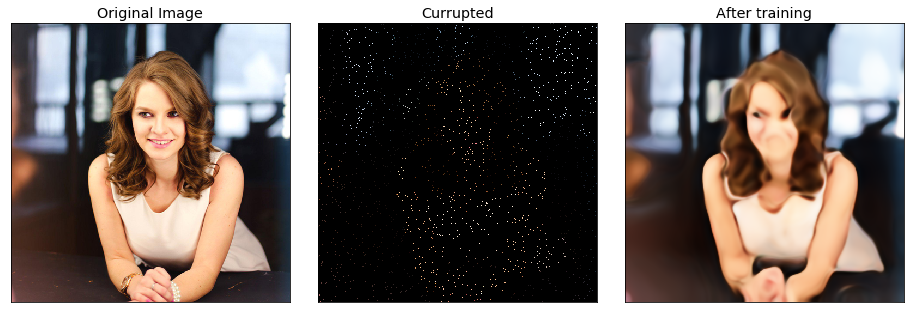

In [90]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = net_input
    output = net(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, target_img[0], output], 
                                        titles=['Original Image', 'Currupted', 'After training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/restoration/{IMAGE}.png')
    regular_trained_output = output

In [91]:
def plot_experiment_results(results, exp_name, fig=None):
    if fig is None:
        fig, _ = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18,12))
    for i, plot_type in enumerate(('psnr_masked', 'psnr', 'loss')):
        ax = fig.axes[i]
        if plot_type not in results:
            continue
        exp_res = results[plot_type]    
        ax.plot(list(range(len(exp_res))), exp_res, label=exp_name)
        ax.set_title(plot_type)
        ax.set_xlabel('iteration')
        ax.legend()
    return fig
experiments_results_fig = None

In [92]:
if training:
    experiments_results_fig = plot_experiment_results({'psnr': psnr_res, 'psnr_masked': psnr_masked_res, 'loss': losses_res}, 'Regular')

# Regular Training with input optimization

In [98]:
TRAIN_TYPE = 'input_optim'

USE_SAME_NET = False
if not USE_SAME_NET:
    if IMAGE == 'barbara':
        net = UNet(input_depth, 1, [128]*5, [128]*5, [4]*5,
                  [3]*5, [3]*5, [1]*5)
    elif IMAGE == 'kate':
        net = UNet(input_depth, 3, [16, 32, 64, 128, 128], [16, 32, 64, 128, 128], [0]*5,
                  [3]*5, [3]*5, [1]*5)
    else:
        assert False
    net.to(device)
new_input = net_input.clone().detach()

In [99]:
# Train, unless final checkpoint is found
training = True
checkpoint_filename = f'{checkpoint_file}_{TRAIN_TYPE}.pt'
checkpoint_file_final = f'{checkpoint_file}_{TRAIN_TYPE}_final.pt'
if os.path.isfile(checkpoint_file_final):
    training = False
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    net.load_state_dict(saved_state['model_state'])
    net_input = saved_state['net_input']
    saved_psnr = saved_state['best_psnr']
    print(f'Best psnr of saved model : {saved_psnr}')
else:
    # Training loop, can change hyperparameters mid way (Regular training)
    if USE_SAME_NET:
        optimizer = torch.optim.Adam([new_input.requires_grad_()], lr=LR)
    else:
        parameters = [x for x in net.parameters()]
        optimizer = torch.optim.Adam([net_input.requires_grad_(), *parameters], lr=LR)

    in_opt_psnr_masked_res = []
    in_opt_psnr_res = []
    in_opt_losses_res = []
    best_psnr = 0
    for i in range(num_iter):
        optimizer.zero_grad()
        out = net(new_input)
        loss = mse(out * mask_tr.unsqueeze(dim=0).to(device), target_img)
        loss.backward()
        psnr_masked = peak_signal_noise_ratio(target_img.detach().cpu().numpy()[0],
                                             out.detach().cpu().numpy()[0] * img_mask_np)
        psnr = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0]) 
        in_opt_psnr_masked_res.append(psnr_masked)
        in_opt_psnr_res.append(psnr)
        in_opt_losses_res.append(loss.item())
        
        if psnr > best_psnr:
            best_psnr = psnr
        
        optimizer.step()
        print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
              (i, loss.item(), psnr_masked, psnr), '\r', end='')
        if i % show_every == 0 and i:
            print('Iteration  %d   Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
                  (i, loss.item(), psnr_masked, psnr))
        if i % (show_every*2) == 0:
            fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                          titles=['Original', f'Iteration: {i}'], cmap='Greys')
    print(f'Done training final Loss = {loss.item()}   PSNR masked= {psnr_masked}   PSNR = {psnr}')
    fig, axes = tensors_as_images([img_tr, out[0].detach()], 
                                        titles=['Original', f'Iteration: {num_iter}'], cmap='Greys')
    saved_state = dict(best_psnr=best_psnr, model_state=net.state_dict(), net_input=net_input)
    torch.save(saved_state, checkpoint_filename)
    print(f'*** Saved checkpoint {checkpoint_filename} ***')

*** Loading final checkpoint file checkpoints/restoration_kate_input_optim_final.pt instead of training
Best psnr of saved model : 25.303524098547726


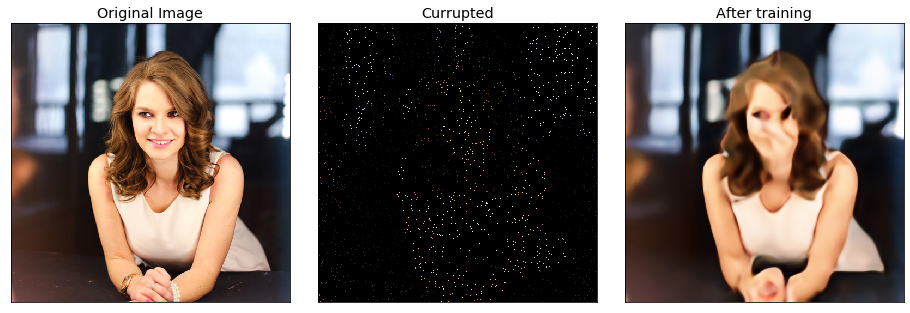

In [100]:
# Showing result of the training using original noise
with torch.no_grad():
    optimized_noise = new_input
    output = net(optimized_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, target_img[0], output], 
                                        titles=['Original Image', 'Currupted', 'After training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/restoration/{IMAGE}_input_optimization.png')
    input_optimized_trained_output = output

In [101]:
if training:
    experiments_results_fig = plot_experiment_results({'psnr': in_opt_psnr_res, 'psnr_masked': in_opt_psnr_masked_res, 'loss': in_opt_losses_res}, 'Input Optim', fig=experiments_results_fig);

# Adverserial training

In [102]:
from models.adverserialModel import *

TRAIN_TYPE = 'adversarial'

# Models
if IMAGE == 'barbara':
    gen = UNet(input_depth, 1, [128]*5, [128]*5, [4]*5,
              [3]*5, [3]*5, [1]*5)
    
    num_iter = 30000
    OPTIMIZE_INPUT = False
    INP_LR = 0.01
    DSC_LR = 0.001
    GEN_LR = 0.001
elif IMAGE == 'kate':
    gen = UNet(input_depth, 3, [16, 32, 64, 128, 128], [16, 32, 64, 128, 128], [0]*5,
              [3]*5, [3]*5, [1]*5)
    
    num_iter = 5000
    OPTIMIZE_INPUT = False
    INP_LR = 0.01
    DSC_LR = 0.0001
    GEN_LR = 0.001
else:
    assert False
    
gen.to(device)
# gen = net 
dsc = Discriminator(img_tr.shape).to(device)

# Hyperparams
DATA_LABEL = 1
LABEL_NOISE = 0.2
weight_decay = 0.005

In [103]:
# net input
adv_input = net_input.clone().detach()

# Optimizers
if OPTIMIZE_INPUT:
    inp_optimizer = torch.optim.Adam([adv_input.requires_grad_()], INP_LR, weight_decay=weight_decay)
dsc_optimizer = torch.optim.Adam(dsc.parameters(), DSC_LR, weight_decay=weight_decay)
gen_optimizer = torch.optim.Adam(gen.parameters(), GEN_LR, weight_decay=weight_decay)

# Loss
def dsc_loss_fn(y_data, y_generated):
    return discriminator_loss_fn(y_data, y_generated, DATA_LABEL, LABEL_NOISE)

def gen_loss_fn(y_generated):
    return generator_loss_fn(y_generated, DATA_LABEL)

def mask_fn(img, mask):
    return img * mask


In [104]:
# Train, unless final checkpoint is found
training = True
checkpoint_filename = f'{checkpoint_file}_{TRAIN_TYPE}.pt'
checkpoint_file_final = f'{checkpoint_file}_{TRAIN_TYPE}_final.pt'
if os.path.isfile(checkpoint_file_final):
    training = False
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    gen.load_state_dict(saved_state['model_state'])
    adv_input = saved_state['net_input']
    saved_psnr = saved_state['best_psnr']
    print(f'Best psnr of saved model : {saved_psnr}')
else:
    # Training loop
    adv_psnr_masked_res = []
    adv_psnr_res = []
    best_psnr = 0
    for i in range(num_iter):
        if OPTIMIZE_INPUT:
            inp_optimizer.zero_grad()
        dsc_loss, gen_loss, output = train_batch(dsc, gen, dsc_loss_fn, gen_loss_fn,
                                        dsc_optimizer, gen_optimizer,
                                        target_img, adv_input,
                                        mask_fn, mask_tr.to(device))
        if OPTIMIZE_INPUT:
            inp_optimizer.step()
        psnr_masked = peak_signal_noise_ratio(target_img.detach().cpu().numpy()[0],
                                             output.detach().cpu().numpy()[0] * img_mask_np)
        psnr = peak_signal_noise_ratio(img_np, output.detach().cpu().numpy()[0]) 
        adv_psnr_masked_res.append(psnr_masked)
        adv_psnr_res.append(psnr)
        if psnr > best_psnr:
            best_psnr = psnr
        
        print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
              (i, gen_loss, dsc_loss, psnr_masked, psnr), '\r', end='')
        if i % show_every == 0 and i:
            print('Iteration  %d   Gen Loss = %06f   Dsc Loss = %06f   PSNR masked = %06f   PSNR = %06f' % 
                  (i, gen_loss, dsc_loss, psnr_masked, psnr))
        if i % (show_every*2) == 0:
            fig, axes = tensors_as_images([img_tr, output[0].detach()], 
                                          titles=['Original', f'Iteration: {i}'], cmap='Greys')
    saved_state = dict(best_psnr=best_psnr, model_state=gen.state_dict(), net_input=adv_input)
    torch.save(saved_state, checkpoint_filename)
    print(f'*** Saved checkpoint {checkpoint_filename} ***')

*** Loading final checkpoint file checkpoints/restoration_kate_adversarial_final.pt instead of training
Best psnr of saved model : 24.259896483179375


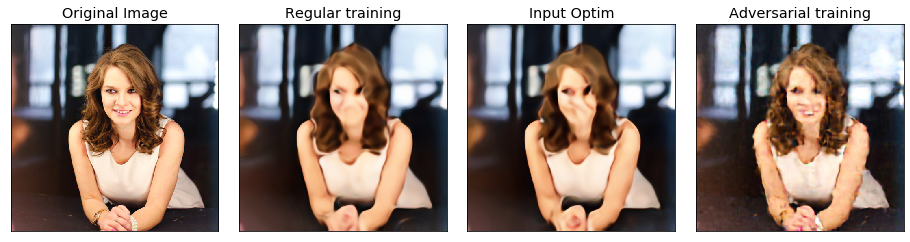

In [105]:
# Showing result of the training using original noise
with torch.no_grad():
    original_noise = adv_input
    output = gen(original_noise).detach()
    output = output.squeeze(dim=0)
    fig, axes = tensors_as_images([img_tr, regular_trained_output, input_optimized_trained_output, output], 
                                        titles=['Original Image', 'Regular training', 'Input Optim', 'Adversarial training'],
                                        figsize=(16,16), cmap='Greys')
    output_pil = np_to_pil(output.detach().cpu().numpy())
    output_pil.save(f'results/restoration/{IMAGE}_adversarial.png')

In [106]:
if training:
    experiments_results_fig = plot_experiment_results({'psnr': adv_psnr_res, 'psnr_masked': adv_psnr_masked_res}, 'Adversarial', fig=experiments_results_fig)